## 1. Web-scraping

In [6]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
import time

chrome_options = Options()
# chrome_options.add_argument("--headless")
driver = webdriver.Chrome(options=chrome_options)
url = 'https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki?limit=50'
driver.get(url)
 
time.sleep(2)
btn_allow = driver.find_element(By.ID, "onetrust-accept-btn-handler")
btn_allow.click()

products_list = {}

driver.maximize_window()

for page in range(2, 18):
    total_height = int(driver.execute_script("return document.body.scrollHeight"))

    for i in range(1, total_height, 2000):
        driver.execute_script("window.scrollTo(0, {});".format(i))
    total_height = int(driver.execute_script("return document.body.scrollHeight"))
    for i in range(1, total_height, 900):
        driver.execute_script("window.scrollTo(0, {});".format(i))

    products_info = driver.find_elements(By.CSS_SELECTOR, ".offer-box.is-ecatalog-loaded.cheaper-by-visible, .offer-box.is-ecatalog-loaded")


    for i, element in enumerate(products_info):
        if element.text != '':
            header = element.find_element(By.CSS_SELECTOR, 'a.is-animate.ui-link')
            price = element.find_elements(By.CSS_SELECTOR, '.main-price.for-action-price.is-big, .main-price.is-big')
            price = price[0].get_attribute('mainprice') if price else None
            link = header.get_attribute('href')
            energy_class = element.find_element(By.CSS_SELECTOR, '.icon-energy-class').get_attribute('alt')
            attributes = element.find_element(By.CSS_SELECTOR, '.list.attributes').find_elements(By.CLASS_NAME, 'item')
            products_list[link] = {'name': header.text, 'price': price, 'energy_class': energy_class}
            
            for attr in attributes:
                name_elements = attr.find_elements(By.CSS_SELECTOR, '.name.attribute')
                value_elements = attr.find_elements(By.CSS_SELECTOR, '.values.attribute')
        
                if name_elements and value_elements:
                    name = name_elements[0].text
                    value = value_elements[0].text
                    products_list[link][name] = value

    driver.get(url + f"&page={page}")
print(len(products_list))

driver.quit()


739


In [230]:
import pandas as pd 
df = pd.DataFrame(products_list)
df.to_csv('scrape_results.csv', index=True)

In [232]:
df = pd.read_csv('scrape_results.csv', index_col=0)
df

,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-hisense-rb470n4efc1-no-frost-200cm-czarna,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-samsung-rb38c774db1-ef-no-frost-203cm-grafitowa,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-beko-b5rcna405hdxbr-beyond-no-frost-dystrybutor-wody-203-5cm-ciemny-inox,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-samsung-rs65dg54r32ceo-side-by-side-no-frost-178cm-czarne-szklo-podajnik-wody-kostkarka,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-grundig-gkpn66940lxrw-no-frost-203-5cm-ciemny-inox,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-hisense-rm469n4afd1-no-frost-200cm-czarna,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-gorenje-rf414eps4-143-6cm-inox,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-beko-b5rcna406lxbw-beyond-harvestfresh-no-frost-203-5cm-platynowa,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-hisense-rs818n4tie-side-by-side-no-frost-179cm-inox-kostkarka,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-hisense-rf632n4wfe1-no-frost-200cm-czarna,...,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-eta-storio-eta253290020e-192-cm-czarna,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-lg-gsgv80epll-side-by-side-no-frost-179cm-czarna-kostkarka-podajnik-wody,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-mpm-215-kb-38-e-150cm-biala,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-indesit-si6-2-s-eu-167cm-srebrna,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-indesit-li8-sn2e-k-1-no-frost-188-9cm-czarna,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-lg-gbv7280dmb-no-frost-203cm-srebrna,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-beko-b1rcna364w-no-frost-186-5cm-biala,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-beko-b1rcna404w-no-frost-203-5cm-biala,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-beko-b5rcna365hg-186-5cm-grafitowa,https://www.mediaexpert.pl/agd/lodowki-i-zamrazarki/lodowki/lodowka-samsung-bespoke-rb34a7b5e12-ef-no-frost-biala-185-3-cm
name,Lodówka HISENSE RB470N4EFC1 No Frost 200cm Cza...,Lodówka SAMSUNG RB38C774DB1 EF AI No Frost 203...,Lodówka BEKO B5RCNA405HDXBR Beyond No Frost Dy...,Lodówka SAMSUNG RS65DG54R32CEO Side by Side AI...,Lodówka GRUNDIG GKPN66940LXRW No Frost 203.5cm...,Lodówka HISENSE RM469N4AFD1 3D No Frost 200cm ...,Lodówka GORENJE RF414EPS4 143.6cm Inox,Lodówka BEKO B5RCNA406LXBW Beyond HarvestFresh...,Lodówka HISENSE RS818N4TIE Side by Side No Fro...,Lodówka HISENSE RF632N4WFE1 4D SkyLine No fros...,...,Lodówka ETA Storio ETA253290020E 192 cm Czarna,Lodówka LG GSGV80EPLL Side by Side No Frost 17...,Lodówka MPM 215-KB-38/E 150cm Biała,Lodówka INDESIT SI6 2 S EU 167cm Srebrna,Lodówka INDESIT LI8 SN2E K 1 No Frost 188.9cm ...,Lodówka LG GBV7280DMB No Frost 203cm Srebrna,Lodówka BEKO B1RCNA364W No Frost 186.5cm Biała...,Lodówka BEKO B1RCNA404W No Frost 203.5cm Biała...,Lodówka BEKO B5RCNA365HG 186.5cm Grafitowa Aer...,Lodówka SAMSUNG BESPOKE RB34A7B5E12 EF No Fros...
price,319989,349989,279989,569600,299991,349999,119989,289989,529999,419989,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
energy_class,Klasa energetyczna C,Klasa energetyczna D,Klasa energetyczna D,Klasa energetyczna E,Klasa energetyczna C,Klasa energetyczna D,Klasa energetyczna E,Klasa energetyczna C,Klasa energetyczna E,Klasa energetyczna E,...,Klasa energetyczna E,Klasa energetyczna E,Klasa energetyczna E,Klasa energetyczna E,Klasa energetyczna E,Klasa energetyczna D,Klasa energetyczna E,Klasa energetyczna E,Klasa energetyczna D,Klasa energetyczna E
Wymiary (WxSxG) [cm]:,200 x 60 x 66.3,203 x 59.5 x 65.8,203.5 x 59.5 x 66.3,178 x 91.2 x 71.6,203.5 x 59.5 x 66.3,200 x 60 x 66.3,143.6 x 55 x 

# 2. Czyszczenie danych

In [233]:
df = pd.read_csv('scrape_results.csv', index_col=0)
df = df.T
df.reset_index(inplace=True)
df.rename(columns={'index': 'link', 'Szerokość z otwartymi drzwiami [cm]:': 'width_opened_doors',
                   'Pojemność [l]:': 'capacity', 'Roczne zużycie prądu:': 'annual_power_consumption',
                   'Bezszronowa (No Frost):': 'no_frost', 'Poziom hałasu [dB]:': 'db',
                   'Panel BESPOKE w zestawie:': 'has_bespoke_panel'}, inplace=True)

if 'energy_class' in df.columns:
    df['energy_class'] = df['energy_class'].str.replace("Klasa energetyczna ", "", regex=False)

df = df.dropna(subset=['capacity'])
df[['fridge_cap', 'freezer_cap']] = df['capacity'].str.extract(r'(\d+)\s*chłodziarka(?:\s*\+\s*(\d+)\s*zamrażarka)?')
df['freezer_cap'] = df['freezer_cap'].fillna(0).astype(float)
df['fridge_cap'] = df['fridge_cap'].astype(float)
df.drop(columns=['capacity'], inplace=True)
    
if 'Wymiary (WxSxG) [cm]:' in df.columns:
    df[['height', 'width', 'depth']] = df['Wymiary (WxSxG) [cm]:'].str.extract(r'(\d+(?:\.\d+)?)\s*x\s*(\d+(?:\.\d+)?)\s*x\s*(\d+(?:\.\d+)?)')
    df.drop(columns=['Wymiary (WxSxG) [cm]:'], inplace=True)

df['annual_power_consumption'] = df['annual_power_consumption'].str.split(' kWh').str[0]

for col in ['price', 'height', 'width', 'depth', 'width_opened_doors', 'db', 'annual_power_consumption']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')
        if col == 'price':
            df[col] = df[col]/100

# no price means product unavailable
if 'price' in df.columns:
    df = df.dropna(subset=['price'])
# it is usually the same as width
df['width_opened_doors'] = df['width_opened_doors'].fillna(df['width'])

df['no_frost'] = df['no_frost'].fillna('Brak')
df['db'] = df['db'].fillna(df['db'].median())
df['has_bespoke_panel'] = df['has_bespoke_panel'].map({'Tak': 1, 'Nie': 0})
df['has_bespoke_panel'] = df['has_bespoke_panel'].fillna(0).astype(int)

df["no_frost"] = df["no_frost"].map({
    "Pełny No Frost": 1,
    "Chłodziarka": 0.5,
    "Zamrażarka": 0.5,
    "Brak": 0
})

energy_map = {
    "A": 1, "B": 2, "C": 3, "D": 4, 
    "E": 5, "F": 6
    }

df["energy_class"] = df["energy_class"].map(energy_map)

## change to categories
for col in ['has_bespoke_panel', 'no_frost', 'energy_class']:
    if col in df.columns:
        df[col] = df[col].astype('category')

df = df.drop_duplicates()
df.info()
df.nunique()


<class 'pandas.core.frame.DataFrame'>
Index: 689 entries, 0 to 689
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   link                      689 non-null    object  
 1   name                      689 non-null    object  
 2   price                     689 non-null    float64 
 3   energy_class              689 non-null    category
 4   width_opened_doors        689 non-null    float64 
 5   annual_power_consumption  689 non-null    float64 
 6   no_frost                  689 non-null    category
 7   db                        689 non-null    float64 
 8   has_bespoke_panel         689 non-null    category
 9   fridge_cap                689 non-null    float64 
 10  freezer_cap               689 non-null    float64 
 11  height                    689 non-null    float64 
 12  width                     689 non-null    float64 
 13  depth                     689 non-null    float64 
dtyp

link                        689
name                        689
price                       423
energy_class                  6
width_opened_doors          128
annual_power_consumption    197
no_frost                      3
db                            9
has_bespoke_panel             2
fridge_cap                  189
freezer_cap                 135
height                      133
width                        61
depth                       121
dtype: int64

In [234]:
df.sample(5)

,link,name,price,energy_class,width_opened_doors,annual_power_consumption,no_frost,db,has_bespoke_panel,fridge_cap,freezer_cap,height,width,depth
533,https://www.mediaexpert.pl/agd/lodowki-i-zamra...,Lodówka BOSCH KGN86AIDR No frost 186cm Srebrna,4999.00,4,86.0,246.0,1.0,38.0,0,479.0,152.0,186.0,86.0,81.0
491,https://www.mediaexpert.pl/agd/lodowki-i-zamra...,Lodówka SAM COOK PSC-WG-1010/B Side by Side No...,3699.91,5,79.0,280.0,1.0,39.0,0,271.0,150.0,180.0,79.0,70.0
140,https://www.mediaexpert.pl/agd/lodowki-i-zamra...,Lodówka SAMSUNG RH69DG805EB1EF Side by Side AI...,7499.99,5,91.6,350.0,1.0,38.0,0,403.0,242.0,178.0,91.2,71.6
642,https://www.mediaexpert.pl/agd/lodowki-i-zamra...,Lodówka MPM 513-SBS-17M No Frost 177cm Inox Si...,4599.99,5,96.0,306.0,1.0,38.0,0,344.0,169.0,177.0,90.0,67.0
617,https://www.mediaexpert.pl/agd/lodowki-i-zamra...,Lodówka CANDY CCT3L517FB 176cm Czarna,1359.97,6,55.5,267.0,0.0,38.0,0,186.0,74.0,176.0,54.5,55.0


# 3. Analiza danych

## 3.1 Kolumny kategoryczne

In [155]:
table1 = pd.crosstab(df['energy_class'], df['no_frost'])
print(table1)

no_frost      0.0  0.5  1.0
energy_class               
1               5    6    9
2               1    0    9
3               5    8   48
4              18    8   80
5             174   14  255
6              26    0   23


In [156]:
table2 = pd.crosstab(df['energy_class'], df['has_bespoke_panel'])
print(table2)

has_bespoke_panel    0  1
energy_class             
1                   18  2
2                   10  0
3                   60  1
4                  102  4
5                  439  4
6                   49  0


In [157]:
table3 = pd.crosstab(df['no_frost'], df['has_bespoke_panel'])
print(table3)

has_bespoke_panel    0   1
no_frost                  
0.0                218  11
0.5                 36   0
1.0                424   0


In [166]:
from scipy.stats import chi2_contingency

# p < 0.05 mozna odrzucic hipoteze 0 ze nie ma zadnych powiazan pomiedzy zmiennymi
chi2, p, dof, expected = chi2_contingency(table1)
print(f"P-value: {p}")
chi2, p, dof, expected = chi2_contingency(table2)
print(f"P-value: {p}")
chi2, p, dof, expected = chi2_contingency(table3)
print(f"P-value: {p}")

P-value: 1.6367114583678938e-13
P-value: 0.012713972697138665
P-value: 1.3306201688617485e-05


## 3.2 Dane ciągłe

In [235]:
from sklearn.linear_model import LinearRegression

correlation_matrix = df[['price', 'fridge_cap', 'freezer_cap', 'energy_class', 'annual_power_consumption']].corr()
print(correlation_matrix)
print(df.dtypes)
X = df[['fridge_cap', 'freezer_cap', 'no_frost', 'energy_class', 'has_bespoke_panel', 'annual_power_consumption', 'db', 'height', 'width', 'depth']]
y = df['price']

model = LinearRegression()
model.fit(X, y)

predictions = model.predict(X)
print(predictions)

                             price  fridge_cap  freezer_cap  energy_class  \
price                     1.000000    0.684587     0.708387     -0.264866   
fridge_cap                0.684587    1.000000     0.825074     -0.179972   
freezer_cap               0.708387    0.825074     1.000000     -0.120978   
energy_class             -0.264866   -0.179972    -0.120978      1.000000   
annual_power_consumption  0.475732    0.677875     0.830143      0.369964   

                          annual_power_consumption  
price                                     0.475732  
fridge_cap                                0.677875  
freezer_cap                               0.830143  
energy_class                              0.369964  
annual_power_consumption                  1.000000  
link                          object
name                          object
price                        float64
energy_class                category
width_opened_doors           float64
annual_power_consumption     float

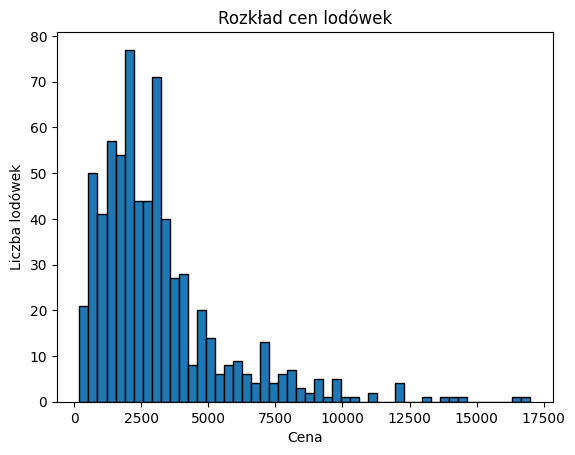

In [160]:
import matplotlib.pyplot as plt

plt.hist(df['price'], bins=50, edgecolor='black')
plt.title('Rozkład cen lodówek')
plt.xlabel('Cena')
plt.ylabel('Liczba lodówek')
plt.show()

In [161]:
print(df[['price', 'fridge_cap', 'freezer_cap', 'height', 'width', 'depth']].describe())

              price  fridge_cap  freezer_cap      height       width  \
count    689.000000  689.000000   689.000000  689.000000  689.000000   
mean    3125.992816  238.507983   100.373004  169.511611   62.902758   
std     2408.825781   97.157599    63.461180   40.439969   13.208268   
min      199.970000   29.000000     0.000000   48.500000   40.000000   
25%     1549.990000  176.000000    54.000000  161.300000   55.000000   
50%     2559.000000  235.000000   103.000000  183.000000   59.500000   
75%     3699.990000  291.000000   125.000000  200.000000   65.400000   
max    16999.000000  487.000000   278.000000  205.000000  100.500000   

            depth  
count  689.000000  
mean    63.551959  
std      7.564196  
min     43.000000  
25%     59.000000  
50%     65.800000  
75%     67.800000  
max     90.000000  


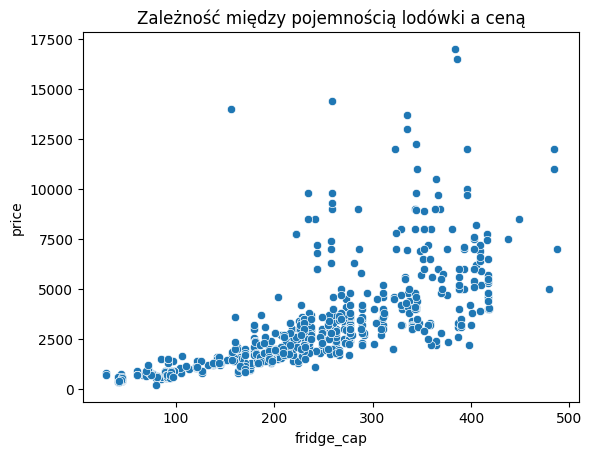

In [162]:
import seaborn as sns

sns.scatterplot(x='fridge_cap', y='price', data=df)
plt.title('Zależność między pojemnością lodówki a ceną')
plt.show()

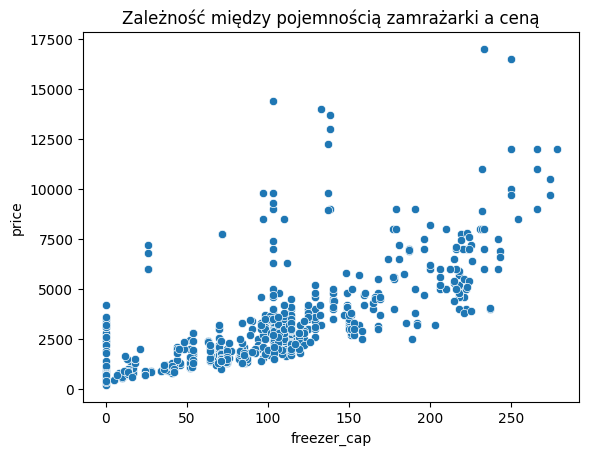

In [163]:
sns.scatterplot(x='freezer_cap', y='price', data=df)
plt.title('Zależność między pojemnością zamrażarki a ceną')
plt.show()

In [164]:
mean_price_by_class = df.groupby('energy_class')['price'].mean()
print(mean_price_by_class)

energy_class
1    5627.077500
2    3978.793000
3    3933.278197
4    3751.746981
5    2842.180451
6    2138.336327
Name: price, dtype: float64


C:\Users\marek\AppData\Local\Temp\ipykernel_8512\2651748510.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  mean_price_by_class = df.groupby('energy_class')['price'].mean()


## 3.3 Wyniki analiz
Na podstawie analiz w 3.1 i w 3.2 można stwierdzić, że:
* Im niższa klasa energetyczna, tym niższa średnia cena lodówek w tej klasie. Klasa A (1) ma średnio najdroższe lodówki.
* Na wykresie zauważalna jest zależność wzrostu cen lodówek, gdy rośnie pojemność ich zamrażarek. Podobną zależność widać dla pojemności lodówek.
* Połowa lodówek jest tańsza lub kosztuje 2559 zł
* Istnieje zależność między zmiennymi energy_class i no_frost.
* Istnieje korelacja pomiędzy ceną a klasą energetyczną lodówki. Jest to korelacja ujemna, zatem gdy rośnie cena maleje numer klasy energetycznej (A = 1) i odwrotnie.
* Widać zależność pomiędzy pojemnością lodówki i zamrażarki a zużyciem energii. Większe lodówki zużywają więcej energii.

# 4. Wizualizacje

R² modelu regresji: 0.5086


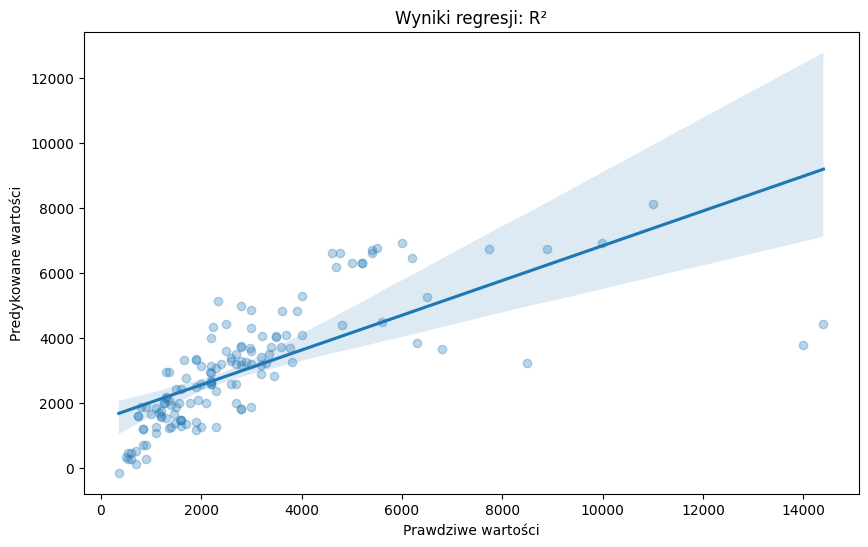

In [222]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

# Model regresji
X = df[['fridge_cap', 'freezer_cap', 'no_frost', 'energy_class', 'has_bespoke_panel', 'annual_power_consumption', 'db', 'height', 'width', 'depth']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

print(f"R² modelu regresji: {r2:.4f}")

plt.figure(figsize=(10, 6))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.3})
plt.title("Wyniki regresji: R²")
plt.xlabel("Prawdziwe wartości")
plt.ylabel("Predykowane wartości")
plt.show()


In [238]:
import plotly.express as px
df1 = df.drop(columns=['link','name'])
correlation_matrix = df1.corr()

fig = px.imshow(correlation_matrix, text_auto=True, title="Macierz korelacji")
fig.show()

Name: nbformat
Version: 5.10.4
Summary: The Jupyter Notebook format
Home-page: https://jupyter.org
Author: 
Author-email: Jupyter Development Team <jupyter@googlegroups.com>
License: BSD 3-Clause License

- Copyright (c) 2001-2015, IPython Development Team
- Copyright (c) 2015-, Jupyter Development Team

All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this
   list of conditions and the following disclaimer.

2. Redistributions in binary form must reproduce the above copyright notice,
   this list of conditions and the following disclaimer in the documentation
   and/or other materials provided with the distribution.

3. Neither the name of the copyright holder nor the names of its
   contributors may be used to endorse or promote products derived from
   this software without specific prior writte

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

# 5. Modelowanie
# 5.1 Porównanie regresji, drzewa decyzyjnego oraz lasu losowego

In [204]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X = df[['fridge_cap', 'freezer_cap', 'no_frost', 'energy_class', 'has_bespoke_panel', 'annual_power_consumption', 'height', 'width', 'depth']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred_lin = lin_reg.predict(X_test)

r2_lin = r2_score(y_test, y_pred_lin)
print(f"R² dla regresji liniowej: {r2_lin:.4f}")



R² dla regresji liniowej: 0.5085


In [205]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(max_depth=5, random_state=42)
tree_reg.fit(X_train, y_train)

y_pred_tree = tree_reg.predict(X_test)

r2_tree = r2_score(y_test, y_pred_tree)
print(f"R² dla drzewa decyzyjnego: {r2_tree:.4f}")

R² dla drzewa decyzyjnego: 0.6854


In [206]:
from sklearn.ensemble import RandomForestRegressor

rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train)

y_pred_rf = rf_reg.predict(X_test)

r2_rf = r2_score(y_test, y_pred_rf)
print(f"R² dla lasu losowego: {r2_rf:.4f}")


R² dla lasu losowego: 0.7183


Na podstawie parametru r2 można stwierdzić że random forrest przewiduje cene lodowki najlepiej.
Możemy sprawdzić na lodówce o wymyślonych parametrach

In [214]:

new_fridge = pd.DataFrame({
    'fridge_cap': [150],
    'freezer_cap': [100],
    'no_frost': [1],
    'energy_class': [3],
    'has_bespoke_panel': [0],
    'annual_power_consumption': [210],
    # 'db': [38],
    'height': [190],
    'width': [70],
    'depth': [65]
})

rf_reg.predict(new_fridge)

array([3740.25329])

### Otrzymaliśmy model który na podstawie parametrów potrafi określić cenę lodówki